In [20]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils


OBSERVER_TYPE = "gaussian"
LESION_PCT = 0.75
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_MODULE_ID = "F5"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 60
BATCH_SIZE = 75

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type="connection",
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=35,
                                              obs_out_dim=OBS_OUT_DIM)

CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Set up the Michaels mRNN

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path())
mike.set_lesion(lesion_instance)
mike.reset()

In [22]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(), with_label=True)

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 1])


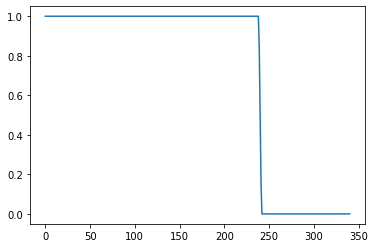

In [120]:
# Hold signal is in the last position
plt.plot(dataset[0][0][:, -1:].detach().numpy())
print(dataset[0][0][:, -1:].shape)
plt.show()

In [44]:
# Question 1: can we find the hold signal?

loss = torch.nn.MSELoss()
model = utils.LSTMModel(OBS_OUT_DIM * 2, 1, num_neurons=OBS_OUT_DIM)
opt = AdamW(model.parameters(), lr=2e-3)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
while ll > 1e-3:
    for batch in loader:
        if ll < 0.1:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        if ll < 0.02:
            for p in opt.param_groups:
                p['lr'] = 3e-5
                
        opt.zero_grad()
        
        din, trial_end, trial_len, dout, dlabel = batch
        steps = din.shape[1]
        batch_size = din.shape[0]
        
        dvis = din[:, :, :-1]
        dhold = din[:, :, -1:]
        
        mike.reset()
        model.reset()
        
        preds = torch.zeros(batch_size, steps, 1)
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)
            
            obs = mike.observe(observer, drop_module_idx=1)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
            pred = model(new_obs)
            preds[:, tidx, :] = pred[:, :]
        
        la = loss(preds, dhold)
        la.backward()
        opt.step()
        ll = la.item()
        print(eidx, ll)
        
        eidx += 1

        
        break
    break
        
        
# Yes. That works

0 0.017514115199446678


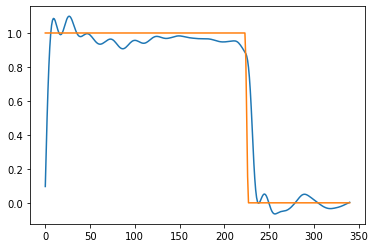

In [45]:
plt.plot(preds[1, :, 0].detach().numpy())
plt.plot(dhold[1, :, 0].detach().numpy())
plt.show()

In [ ]:
# Question 2: can we separate the classes?

loss = nn.CrossEntropyLoss()
model = utils.LSTMModel(3*OBS_OUT_DIM, 7, num_neurons=3*OBS_OUT_DIM)
opt = AdamW(model.parameters(), lr=1e-3)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
while ll > 0.5:
    for batch in loader:
        if ll >= 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-3
        elif ll < 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-5
        elif ll < 1.3:
            for p in opt.param_groups:
                p['lr'] = 5e-6
        elif ll < 1:
            for p in opt.param_groups:
                p['lr'] = 3e-6
        
        din, trial_end, trial_len, dout, dlabel = batch
        
        # Let's actually see if the early trial info is enough...
        steps = din.shape[1]
        #steps = 231
        batch_size = din.shape[0]
        
        opt.zero_grad() 
        mike.reset()
        model.reset()
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)
            
            obs = mike.observe(observer)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
            pred = model(new_obs)
        
        la = loss(pred, dlabel)
        
        correct = 0
        for x in range(batch_size):
            m = torch.argmax(pred[x, :])
            if m == dlabel[x]:
                correct += 1
        print(eidx, f"{correct}/{batch_size}", la.item())
        
        eidx += 1
        la.backward()
        opt.step()
        ll = la.item()



0 12/75 1.9425711631774902
1 13/75 1.9487054347991943
2 5/75 1.963911771774292
3 11/75 1.9438468217849731
4 10/75 1.9466540813446045
5 12/75 1.9542884826660156
6 8/52 1.9385063648223877
7 16/75 1.9294790029525757
8 10/75 1.9438598155975342
9 8/75 1.9482755661010742
10 11/75 1.9482914209365845
11 9/75 1.95268976688385
12 13/75 1.9416029453277588
13 4/52 1.9611434936523438
14 18/75 1.9358267784118652
15 10/75 1.9433152675628662
16 11/75 1.9337190389633179
17 12/75 1.9410516023635864
18 7/75 1.9522188901901245
19 5/75 1.953830361366272
20 8/52 1.9353419542312622
21 12/75 1.938236951828003
22 10/75 1.9446382522583008
23 9/75 1.9425835609436035
24 9/75 1.9420127868652344
25 9/75 1.939784288406372
26 14/75 1.928687572479248
27 8/52 1.9321602582931519
28 11/75 1.9288097620010376
29 11/75 1.9350087642669678
30 11/75 1.9357205629348755
31 19/75 1.9283469915390015
32 13/75 1.9298378229141235
33 27/75 1.9169169664382935
34 14/52 1.9192769527435303
35 32/75 1.913159966468811
36 28/75 1.90292358398

291 33/75 1.517147183418274
292 26/75 1.620200753211975
293 17/52 1.6781370639801025
294 30/75 1.6312192678451538
295 28/75 1.6373920440673828
296 28/75 1.7324198484420776
297 33/75 1.5413894653320312
298 34/75 1.5547412633895874
299 24/75 1.5733451843261719
300 19/52 1.6089186668395996
301 24/75 1.6462724208831787
302 38/75 1.4659631252288818
303 32/75 1.601807951927185
304 27/75 1.63689124584198
305 30/75 1.6243224143981934
306 27/75 1.5854226350784302
307 12/52 1.6762548685073853
308 31/75 1.5528604984283447
309 30/75 1.5528314113616943
310 29/75 1.5787376165390015
311 34/75 1.5309960842132568
312 23/75 1.5714282989501953
313 27/75 1.5992587804794312
314 19/52 1.5904687643051147
315 27/75 1.5902019739151
316 39/75 1.5069431066513062
317 22/75 1.6234302520751953
318 31/75 1.5949528217315674
319 30/75 1.529963731765747
320 26/75 1.5545246601104736
321 23/52 1.4623255729675293
322 32/75 1.5214793682098389
323 38/75 1.4769597053527832
324 25/75 1.5784138441085815
325 32/75 1.55790615081

576 33/75 1.4735453128814697
577 34/75 1.4747437238693237
578 32/75 1.4861037731170654
579 35/75 1.4489631652832031
580 19/52 1.4987627267837524
581 36/75 1.422426700592041
582 32/75 1.4558296203613281
583 31/75 1.4559849500656128
584 35/75 1.4215716123580933
585 29/75 1.5353004932403564
586 38/75 1.4498599767684937
587 19/52 1.5434229373931885
588 28/75 1.4875633716583252
589 31/75 1.5243932008743286
590 35/75 1.4198168516159058
591 36/75 1.4610236883163452
592 35/75 1.410148024559021
593 36/75 1.4322404861450195
594 19/52 1.5463738441467285
595 31/75 1.46952223777771
596 33/75 1.4262185096740723
597 29/75 1.510486364364624
598 41/75 1.4036588668823242
599 34/75 1.4830597639083862
600 32/75 1.4735960960388184
601 19/52 1.4960532188415527
602 39/75 1.3991585969924927
603 28/75 1.5189400911331177
604 32/75 1.4543535709381104
605 34/75 1.4396311044692993
606 31/75 1.4860680103302002
607 35/75 1.5219054222106934
608 21/52 1.4142760038375854
609 38/75 1.4543343782424927
610 33/75 1.4273365

861 35/75 1.4073858261108398
862 33/75 1.4832147359848022
863 30/75 1.4433047771453857
864 32/75 1.4246240854263306
865 30/75 1.4521480798721313
866 32/75 1.4927067756652832
867 21/52 1.4223003387451172
868 28/75 1.4743316173553467
869 32/75 1.4449474811553955
870 33/75 1.4218121767044067
871 33/75 1.4173004627227783
872 34/75 1.4161289930343628
873 33/75 1.4663290977478027
874 19/52 1.5080376863479614
875 25/75 1.527980923652649
876 30/75 1.3708817958831787
877 23/75 1.500649333000183
878 37/75 1.4263050556182861
879 32/75 1.441462755203247
880 38/75 1.4303346872329712
881 28/52 1.4206347465515137
882 35/75 1.4020344018936157
883 29/75 1.5185648202896118
884 29/75 1.498896837234497
885 29/75 1.482553243637085
886 40/75 1.3498294353485107
887 27/75 1.4696719646453857
888 26/52 1.3819472789764404
889 33/75 1.398138165473938
890 38/75 1.3440419435501099
891 37/75 1.4674605131149292
892 26/75 1.457643985748291
893 32/75 1.4491796493530273
894 27/75 1.5317105054855347
895 21/52 1.483231425

1142 29/75 1.4762604236602783
1143 30/75 1.4041212797164917
1144 37/75 1.4418786764144897
1145 30/75 1.4278512001037598
1146 32/75 1.3852366209030151
1147 22/52 1.401049256324768
1148 37/75 1.4059898853302002
1149 34/75 1.446340799331665
1150 36/75 1.360682487487793
1151 34/75 1.385514736175537
1152 21/75 1.5594006776809692
1153 30/75 1.4002304077148438
1154 19/52 1.4419816732406616
1155 31/75 1.4431921243667603
1156 29/75 1.438832402229309
1157 31/75 1.422100305557251
1158 26/75 1.4936110973358154
1159 36/75 1.4037895202636719
1160 33/75 1.3835362195968628
1161 25/52 1.3978546857833862
1162 34/75 1.3659172058105469
1163 32/75 1.4360873699188232
1164 30/75 1.4305763244628906
1165 31/75 1.447637677192688
1166 34/75 1.4364736080169678
1167 31/75 1.4433461427688599
1168 23/52 1.428071141242981
1169 29/75 1.4552600383758545
1170 29/75 1.4944350719451904
1171 27/75 1.4635289907455444
1172 33/75 1.3733439445495605
1173 36/75 1.3831405639648438
1174 35/75 1.39933180809021
1175 25/52 1.4131391

1418 27/75 1.458348274230957
1419 28/75 1.4898220300674438
1420 27/52 1.3423709869384766
1421 36/75 1.3626009225845337
1422 33/75 1.4013077020645142
1423 29/75 1.4609237909317017
1424 32/75 1.3741992712020874
1425 29/75 1.470518708229065
1426 31/75 1.3915244340896606
1427 24/52 1.3832331895828247
1428 29/75 1.4521318674087524
1429 34/75 1.4274439811706543
1430 27/75 1.399689793586731
1431 30/75 1.366916537284851
1432 35/75 1.4008907079696655
1433 35/75 1.4197843074798584
1434 22/52 1.3737715482711792
1435 31/75 1.4100496768951416
1436 39/75 1.3304208517074585
1437 36/75 1.341908574104309
1438 27/75 1.4239004850387573
1439 36/75 1.4584341049194336
1440 31/75 1.4007714986801147
1441 16/52 1.5067212581634521
1442 38/75 1.3909190893173218
1443 35/75 1.376799464225769
1444 34/75 1.3316662311553955
1445 24/75 1.497336983680725
1446 31/75 1.3845981359481812
1447 35/75 1.4021060466766357
1448 17/52 1.477671504020691
1449 36/75 1.359321117401123
1450 33/75 1.4013006687164307
1451 34/75 1.361874

1693 25/52 1.332365870475769
1694 33/75 1.354062557220459
1695 31/75 1.402754306793213
1696 36/75 1.3106402158737183
1697 31/75 1.431807279586792
1698 33/75 1.353834629058838
1699 31/75 1.4362139701843262
1700 19/52 1.4219491481781006
1701 38/75 1.3470032215118408
1702 31/75 1.4235577583312988
1703 35/75 1.4143245220184326
1704 27/75 1.4107003211975098
1705 28/75 1.3963481187820435
1706 33/75 1.3133419752120972
1707 21/52 1.3942062854766846
1708 35/75 1.3235794305801392
1709 30/75 1.4507153034210205
1710 33/75 1.3592941761016846
1711 38/75 1.359020471572876
1712 26/75 1.4212301969528198
1713 28/75 1.3927547931671143
1714 23/52 1.389068841934204
1715 35/75 1.3372770547866821
1716 31/75 1.429337739944458
1717 28/75 1.42654287815094
1718 37/75 1.3538888692855835
1719 21/75 1.422253131866455
1720 33/75 1.399078607559204
1721 29/52 1.2920087575912476
1722 27/75 1.4041515588760376
1723 30/75 1.3861050605773926
1724 36/75 1.3736302852630615
1725 29/75 1.4636374711990356
1726 42/75 1.243600249

1969 27/75 1.455039143562317
1970 32/75 1.3109536170959473
1971 29/75 1.3329193592071533
1972 36/75 1.3452224731445312
1973 21/52 1.4278379678726196
1974 28/75 1.4103690385818481
1975 36/75 1.3366236686706543
1976 35/75 1.326339840888977
1977 33/75 1.3116517066955566
1978 32/75 1.3843903541564941
1979 33/75 1.3982292413711548
1980 21/52 1.3823879957199097
1981 31/75 1.3990719318389893
1982 32/75 1.3703505992889404
1983 28/75 1.391120433807373
1984 30/75 1.420859932899475
1985 30/75 1.3940722942352295
1986 40/75 1.2545865774154663
1987 26/52 1.286402940750122
1988 34/75 1.3660297393798828
1989 34/75 1.3823922872543335
1990 34/75 1.3331243991851807
1991 25/75 1.45257568359375
1992 35/75 1.3232088088989258
1993 35/75 1.3104368448257446
1994 20/52 1.3702749013900757
1995 31/75 1.3462203741073608
1996 36/75 1.2994797229766846
1997 35/75 1.366300106048584
1998 35/75 1.3774548768997192
1999 29/75 1.3919250965118408
2000 31/75 1.3791284561157227
2001 19/52 1.383841633796692
2002 29/75 1.401667

2245 41/75 1.2682000398635864
2246 24/52 1.449676275253296
2247 33/75 1.3119126558303833
2248 35/75 1.2917754650115967
2249 38/75 1.2947652339935303
2250 37/75 1.369470477104187
2251 28/75 1.3697704076766968
2252 25/75 1.3837891817092896
2253 22/52 1.3749936819076538
2254 34/75 1.314516544342041
2255 35/75 1.3611664772033691
2256 32/75 1.3246859312057495
2257 26/75 1.3995925188064575
2258 34/75 1.3137779235839844
2259 39/75 1.302479863166809
2260 18/52 1.3789336681365967
2261 36/75 1.3260931968688965
2262 32/75 1.2806082963943481
2263 28/75 1.3771545886993408
2264 35/75 1.368645191192627
2265 38/75 1.2514480352401733
2266 31/75 1.3842203617095947
2267 18/52 1.4150264263153076
2268 26/75 1.3552788496017456
2269 32/75 1.3610752820968628
2270 36/75 1.2740775346755981
2271 33/75 1.3804938793182373
2272 35/75 1.3339061737060547
2273 34/75 1.3787728548049927
2274 23/52 1.2705110311508179
2275 24/75 1.4131146669387817
2276 37/75 1.2427031993865967
2277 28/75 1.3997067213058472
2278 34/75 1.38

2521 34/75 1.3263858556747437
2522 35/75 1.2985011339187622
2523 30/75 1.3571200370788574
2524 36/75 1.2486631870269775
2525 29/75 1.3776484727859497
2526 24/52 1.3212904930114746
2527 32/75 1.3006665706634521
2528 42/75 1.2532386779785156
2529 24/75 1.3906606435775757
2530 38/75 1.2283439636230469
2531 28/75 1.3961254358291626
2532 36/75 1.3223955631256104
2533 22/52 1.3470513820648193
2534 33/75 1.3515095710754395
2535 32/75 1.3168675899505615
2536 33/75 1.333471417427063
2537 31/75 1.3006178140640259
2538 32/75 1.3086053133010864
2539 33/75 1.3378431797027588
2540 25/52 1.2588717937469482
2541 31/75 1.3219966888427734
2542 26/75 1.2793623208999634
2543 33/75 1.3173933029174805
2544 30/75 1.348380208015442
2545 41/75 1.294772982597351
2546 31/75 1.377943754196167
2547 27/52 1.264064908027649
2548 29/75 1.3892866373062134
2549 30/75 1.460456132888794
2550 37/75 1.2054946422576904
2551 32/75 1.2911893129348755
2552 40/75 1.3035138845443726
2553 30/75 1.2778797149658203
2554 25/52 1.276

2796 35/75 1.311370849609375
2797 34/75 1.312418818473816
2798 38/75 1.2800718545913696
2799 20/52 1.2871485948562622
2800 27/75 1.4095546007156372
2801 37/75 1.2709624767303467
2802 38/75 1.2904307842254639
2803 37/75 1.3015724420547485
2804 36/75 1.2550897598266602
2805 29/75 1.2807934284210205
2806 24/52 1.2355347871780396
2807 42/75 1.2475534677505493
2808 37/75 1.249358892440796
2809 34/75 1.2911819219589233
2810 35/75 1.2747364044189453
2811 31/75 1.3481271266937256
2812 27/75 1.3438467979431152
2813 21/52 1.3225817680358887
2814 41/75 1.3047198057174683
2815 40/75 1.2358789443969727
2816 28/75 1.3426787853240967
2817 32/75 1.2571741342544556
2818 34/75 1.2421927452087402
2819 32/75 1.346184253692627
2820 20/52 1.3196678161621094
2821 28/75 1.3401144742965698
2822 32/75 1.3416980504989624
2823 34/75 1.3380721807479858
2824 36/75 1.2770798206329346
2825 36/75 1.259827971458435
2826 31/75 1.3190124034881592
2827 31/52 1.104668140411377
2828 41/75 1.2041338682174683
2829 33/75 1.234

3072 26/52 1.3543719053268433
3073 34/75 1.195994257926941
3074 26/75 1.2834844589233398
3075 33/75 1.3628572225570679
3076 38/75 1.2283552885055542
3077 43/75 1.2209395170211792
3078 39/75 1.3318276405334473
3079 22/52 1.2454828023910522
3080 29/75 1.2695890665054321
3081 32/75 1.3469418287277222
3082 41/75 1.2352544069290161
3083 44/75 1.2067803144454956
3084 33/75 1.280882716178894
3085 31/75 1.319974422454834
3086 25/52 1.1812530755996704
3087 35/75 1.3297940492630005
3088 31/75 1.304874300956726
3089 33/75 1.2760189771652222
3090 38/75 1.2482459545135498
3091 40/75 1.2056423425674438
3092 33/75 1.2780890464782715
3093 25/52 1.1972079277038574
3094 37/75 1.216610312461853
3095 37/75 1.27787184715271
3096 37/75 1.2392923831939697
3097 37/75 1.2484862804412842
3098 26/75 1.3496612310409546
3099 38/75 1.2538940906524658
3100 23/52 1.2723418474197388
3101 34/75 1.259822130203247
3102 32/75 1.3010865449905396
3103 36/75 1.2593879699707031
3104 38/75 1.2360453605651855
3105 38/75 1.29639

3349 35/75 1.2744182348251343
3350 37/75 1.1825224161148071
3351 34/75 1.2636038064956665
3352 24/52 1.2540898323059082
3353 34/75 1.1977958679199219
3354 31/75 1.193700909614563
3355 32/75 1.2485167980194092
3356 35/75 1.2596781253814697
3357 31/75 1.3019533157348633
3358 40/75 1.1941266059875488
3359 23/52 1.2389553785324097
3360 37/75 1.2240569591522217
3361 33/75 1.2351917028427124
3362 35/75 1.2138372659683228
3363 37/75 1.2470505237579346
3364 31/75 1.265309453010559
3365 32/75 1.2267855405807495
3366 25/52 1.2074216604232788
3367 31/75 1.261900782585144
3368 37/75 1.1840627193450928
3369 28/75 1.2586873769760132
3370 33/75 1.2565131187438965
3371 37/75 1.2067657709121704
3372 33/75 1.2480770349502563
3373 27/52 1.200485348701477
3374 38/75 1.1878623962402344
3375 31/75 1.34681236743927
3376 33/75 1.1605042219161987
3377 30/75 1.2974083423614502
3378 39/75 1.1998957395553589
3379 34/75 1.206817626953125
3380 24/52 1.2036787271499634
3381 35/75 1.2003334760665894
3382 35/75 1.1801

3625 22/52 1.1853128671646118
3626 45/75 1.113163709640503
3627 34/75 1.1521345376968384
3628 39/75 1.1534861326217651
3629 34/75 1.310797095298767
3630 29/75 1.201851487159729
3631 37/75 1.1791977882385254
3632 23/52 1.2364641427993774
3633 38/75 1.194380521774292
3634 41/75 1.1249613761901855
3635 34/75 1.209895372390747
3636 31/75 1.2531254291534424
3637 40/75 1.1226143836975098
3638 34/75 1.2369617223739624
3639 23/52 1.1881873607635498
3640 33/75 1.2634233236312866
3641 47/75 1.1276166439056396
3642 36/75 1.1945223808288574
3643 35/75 1.1511361598968506
3644 33/75 1.187029242515564
3645 37/75 1.1345475912094116
3646 19/52 1.3019139766693115
3647 31/75 1.304055094718933
3648 41/75 1.1351948976516724
3649 36/75 1.1729198694229126
3650 36/75 1.2051844596862793
3651 39/75 1.1618318557739258
3652 31/75 1.177085518836975
3653 27/52 1.155268669128418
3654 35/75 1.2326421737670898
3655 39/75 1.1775641441345215
3656 34/75 1.1771217584609985
3657 44/75 1.1049305200576782
3658 29/75 1.227436

3900 36/75 1.2118291854858398
3901 41/75 1.15227472782135
3902 36/75 1.2399694919586182
3903 42/75 1.1482888460159302
3904 33/75 1.2133598327636719
3905 26/52 1.226163625717163
3906 31/75 1.2689112424850464
3907 36/75 1.242591381072998
3908 37/75 1.1626275777816772
3909 35/75 1.1398112773895264
3910 52/75 1.1407486200332642
3911 33/75 1.3035008907318115
3912 25/52 1.2696759700775146
3913 39/75 1.165852665901184
3914 36/75 1.3263872861862183
3915 35/75 1.3139058351516724
3916 38/75 1.2430099248886108
3917 34/75 1.1544946432113647
3918 38/75 1.1378083229064941
3919 29/52 1.1534548997879028
3920 34/75 1.3031573295593262
3921 39/75 1.1764984130859375
3922 25/75 1.2299221754074097
3923 37/75 1.220109462738037
3924 46/75 1.225898265838623
3925 43/75 1.1541072130203247
3926 25/52 1.1848951578140259
3927 41/75 1.159701943397522
3928 37/75 1.264758825302124
3929 34/75 1.3040525913238525
3930 38/75 1.2174582481384277
3931 39/75 1.1406657695770264
3932 40/75 1.1997994184494019
3933 19/52 1.265142

4176 37/75 1.2223762273788452
4177 38/75 1.247679591178894
4178 26/52 1.2081224918365479
4179 32/75 1.2718077898025513
4180 36/75 1.252034068107605
4181 39/75 1.1556748151779175
4182 37/75 1.1803884506225586
4183 43/75 1.206155776977539
4184 44/75 1.3012734651565552
4185 23/52 1.2941629886627197
4186 38/75 1.3266592025756836
4187 37/75 1.2575762271881104
4188 36/75 1.129564881324768
4189 39/75 1.2561109066009521
4190 36/75 1.2057186365127563
4191 44/75 1.1872166395187378
4192 24/52 1.2814172506332397
4193 46/75 1.0234991312026978
4194 40/75 1.1973522901535034
4195 32/75 1.2974815368652344
4196 35/75 1.334755539894104
4197 35/75 1.3141686916351318
4198 39/75 1.203736662864685
4199 26/52 1.2921899557113647
4200 32/75 1.2942757606506348
4201 36/75 1.184975266456604
4202 41/75 1.1832300424575806
4203 40/75 1.1994950771331787
4204 33/75 1.365077257156372
4205 41/75 1.2092247009277344
4206 32/52 1.1545207500457764
4207 34/75 1.3280880451202393
4208 41/75 1.201918601989746
4209 34/75 1.290561

4452 42/75 1.1637694835662842
4453 34/75 1.2427340745925903
4454 36/75 1.265541434288025
4455 36/75 1.3335580825805664
4456 41/75 1.2792531251907349
4457 37/75 1.2710901498794556
4458 33/52 1.100563883781433
4459 44/75 1.1987086534500122
4460 34/75 1.340218186378479
4461 33/75 1.3418673276901245
4462 42/75 1.2000662088394165
4463 47/75 1.1754647493362427
4464 36/75 1.2609574794769287
4465 22/52 1.1623764038085938
4466 42/75 1.2605725526809692
4467 42/75 1.1012886762619019
4468 38/75 1.228455662727356
4469 33/75 1.298783540725708
4470 32/75 1.351822853088379
4471 43/75 1.2678415775299072
4472 26/52 1.1644599437713623
4473 44/75 1.1478629112243652
4474 33/75 1.345298409461975
4475 41/75 1.1376408338546753
4476 40/75 1.279450535774231
4477 37/75 1.262321949005127
4478 40/75 1.2398419380187988
4479 21/52 1.2866305112838745
4480 37/75 1.2071549892425537
4481 38/75 1.2207517623901367
4482 28/75 1.3766942024230957
4483 51/75 1.0947773456573486
4484 36/75 1.3427757024765015
4485 40/75 1.223778

4727 34/75 1.3254934549331665
4728 36/75 1.2327007055282593
4729 45/75 1.1557371616363525
4730 39/75 1.2387564182281494
4731 26/52 1.237385630607605
4732 37/75 1.2959131002426147
4733 44/75 1.1659836769104004
4734 40/75 1.2260342836380005
4735 41/75 1.164979338645935
4736 30/75 1.3265005350112915
4737 44/75 1.1948881149291992
4738 26/52 1.176165223121643
4739 40/75 1.1423680782318115
4740 32/75 1.3382163047790527
4741 41/75 1.1892436742782593
4742 42/75 1.1940921545028687
4743 43/75 1.2344145774841309
4744 37/75 1.2616873979568481
4745 27/52 1.1935927867889404
4746 44/75 1.1929428577423096
4747 39/75 1.209675669670105
4748 48/75 1.1207211017608643
4749 35/75 1.194993495941162
4750 38/75 1.2672299146652222
4751 36/75 1.3728830814361572
4752 24/52 1.194240689277649
4753 40/75 1.2147221565246582
4754 44/75 1.2275774478912354
4755 41/75 1.2846570014953613
4756 35/75 1.1381281614303589
4757 40/75 1.2174686193466187
4758 38/75 1.2150050401687622
4759 26/52 1.2750906944274902
4760 48/75 1.149

5002 41/75 1.1739710569381714
5003 40/75 1.1362894773483276
5004 19/52 1.3367774486541748
5005 51/75 1.0827239751815796
5006 45/75 1.1418251991271973
5007 32/75 1.2512575387954712
5008 39/75 1.2846481800079346
5009 36/75 1.287434697151184
5010 42/75 1.1960840225219727
5011 24/52 1.197851538658142
5012 43/75 1.2421396970748901
5013 36/75 1.2284605503082275
5014 40/75 1.217767357826233
5015 38/75 1.2554112672805786
5016 41/75 1.1371811628341675
5017 42/75 1.156257152557373
5018 29/52 1.2069487571716309
5019 39/75 1.2394483089447021
5020 36/75 1.2161635160446167
5021 44/75 1.1791625022888184
5022 42/75 1.234345555305481
5023 37/75 1.250510811805725
5024 45/75 1.0902138948440552
5025 26/52 1.238025426864624
5026 39/75 1.1984394788742065
5027 46/75 1.2690197229385376
5028 42/75 1.2437399625778198
5029 32/75 1.2539902925491333
5030 40/75 1.174934983253479
5031 40/75 1.1102381944656372
5032 30/52 1.1761140823364258
5033 37/75 1.2364635467529297
5034 44/75 1.128602147102356
5035 43/75 1.182078

5278 36/75 1.1841983795166016
5279 42/75 1.1746165752410889
5280 45/75 1.2057017087936401
5281 42/75 1.2410496473312378
5282 40/75 1.2177436351776123
5283 43/75 1.1556447744369507
5284 30/52 1.1405659914016724
5285 41/75 1.23977792263031
5286 46/75 1.0890201330184937
5287 37/75 1.2244685888290405
5288 45/75 1.1498041152954102
5289 31/75 1.2973345518112183
5290 42/75 1.173134207725525
5291 36/52 1.1444334983825684
5292 40/75 1.1852836608886719
5293 43/75 1.1469874382019043
5294 41/75 1.1490765810012817
5295 44/75 1.182578682899475
5296 37/75 1.3291724920272827
5297 39/75 1.1820170879364014
5298 34/52 1.1390552520751953
5299 46/75 1.1092116832733154
5300 43/75 1.1840486526489258
5301 36/75 1.2125014066696167
5302 42/75 1.2430492639541626
5303 46/75 1.1392582654953003
5304 38/75 1.2138701677322388
5305 25/52 1.2401478290557861
5306 37/75 1.240766167640686
5307 41/75 1.219152569770813
5308 46/75 1.127941608428955
5309 39/75 1.2019004821777344
5310 40/75 1.1987422704696655
5311 41/75 1.2161

5554 40/75 1.0986994504928589
5555 34/75 1.163253664970398
5556 38/75 1.3117753267288208
5557 33/52 1.1241120100021362
5558 40/75 1.2556313276290894
5559 46/75 1.0496938228607178
5560 40/75 1.0230703353881836
5561 43/75 1.285841941833496
5562 41/75 1.2019143104553223
5563 38/75 1.202117681503296
5564 29/52 1.2170145511627197
5565 42/75 1.2005914449691772
5566 44/75 1.0900644063949585
5567 39/75 1.1681796312332153
5568 42/75 1.175828456878662
5569 38/75 1.2557497024536133
5570 40/75 1.1761817932128906
5571 32/52 1.1435402631759644
5572 37/75 1.1803805828094482
5573 41/75 1.1899232864379883
5574 36/75 1.23160719871521
5575 41/75 1.1097767353057861
5576 43/75 1.2184741497039795
5577 48/75 1.0992954969406128
5578 30/52 1.193645715713501
5579 46/75 1.1132094860076904
5580 48/75 1.0847771167755127
5581 44/75 1.1693065166473389
5582 42/75 1.1561418771743774
5583 36/75 1.1884790658950806
5584 36/75 1.2513762712478638
5585 22/52 1.288226842880249
5586 41/75 1.1891193389892578
5587 44/75 1.17746

5830 33/52 1.207541584968567
5831 44/75 1.1753785610198975
5832 37/75 1.1598671674728394
5833 39/75 1.2194633483886719
5834 48/75 1.1507247686386108
5835 44/75 1.1201618909835815
5836 38/75 1.1654436588287354
5837 30/52 1.130675196647644
5838 46/75 1.1155457496643066
5839 40/75 1.1021112203598022
5840 35/75 1.2586699724197388
5841 41/75 1.1757233142852783
5842 46/75 1.1407661437988281
5843 40/75 1.1807743310928345
5844 33/52 1.1543583869934082
5845 38/75 1.1300572156906128
5846 35/75 1.1598376035690308
5847 53/75 1.0747936964035034
5848 37/75 1.1941742897033691
5849 44/75 1.2778533697128296
5850 39/75 1.1857327222824097
5851 35/52 1.081349492073059
5852 42/75 1.126426339149475
5853 51/75 1.0721412897109985
5854 36/75 1.3064870834350586
5855 41/75 1.1167795658111572
5856 46/75 1.175601840019226
5857 40/75 1.1649776697158813
5858 25/52 1.1609687805175781
5859 41/75 1.1634420156478882
5860 43/75 1.1849713325500488
5861 45/75 1.1406704187393188
5862 43/75 1.0921725034713745
5863 41/75 1.20

6106 45/75 1.1482616662979126
6107 40/75 1.141003966331482
6108 47/75 1.1273142099380493
6109 46/75 1.1211384534835815
6110 26/52 1.167709231376648
6111 42/75 1.0922491550445557
6112 42/75 1.1800566911697388
6113 41/75 1.1866856813430786
6114 48/75 1.076656460762024
6115 44/75 1.1304810047149658
6116 40/75 1.245826244354248
6117 30/52 1.1292717456817627
6118 41/75 1.16470468044281
6119 42/75 1.191189169883728
6120 48/75 1.1361286640167236
6121 43/75 1.0774240493774414
6122 43/75 1.1811583042144775
6123 40/75 1.0991560220718384
6124 31/52 1.2159346342086792
6125 43/75 1.1559722423553467
6126 38/75 1.2387334108352661
6127 42/75 1.2066333293914795
6128 48/75 1.073641300201416
6129 44/75 1.1408864259719849
6130 40/75 1.118192195892334
6131 33/52 1.0908104181289673
6132 39/75 1.2082829475402832
6133 50/75 1.0676480531692505
6134 44/75 1.089953899383545
6135 39/75 1.1848129034042358
6136 46/75 1.1885311603546143
6137 42/75 1.0831669569015503
6138 28/52 1.249556303024292
6139 43/75 1.11874771

6382 42/75 1.1458834409713745
6383 36/52 1.0838509798049927
6384 38/75 1.2076855897903442
6385 47/75 1.0807833671569824
6386 37/75 1.1897860765457153
6387 45/75 1.0778759717941284
6388 48/75 1.171420693397522
6389 51/75 1.0860836505889893
6390 26/52 1.1631277799606323
6391 41/75 1.163262963294983
6392 43/75 1.222861409187317
6393 42/75 1.140574336051941
6394 47/75 1.1018047332763672
6395 51/75 1.070679783821106
6396 40/75 1.1252011060714722
6397 29/52 1.1451102495193481
6398 41/75 1.215212345123291
6399 46/75 1.0570335388183594
6400 40/75 1.1379928588867188
6401 45/75 1.0633021593093872
6402 45/75 1.1524004936218262
6403 42/75 1.207458734512329
6404 33/52 1.1309562921524048
6405 39/75 1.1526845693588257
6406 47/75 1.064080834388733
6407 46/75 1.08458411693573
6408 43/75 1.1104226112365723
6409 45/75 1.192366361618042
6410 41/75 1.1612643003463745
6411 31/52 1.2235029935836792
6412 42/75 1.1151330471038818
6413 41/75 1.1886417865753174
6414 47/75 1.1476439237594604
6415 45/75 1.13627171

6658 46/75 1.0165317058563232
6659 42/75 1.160336971282959
6660 46/75 1.1249958276748657
6661 47/75 1.113600254058838
6662 42/75 1.089787244796753
6663 26/52 1.211877703666687
6664 46/75 1.0819686651229858
6665 40/75 1.1621484756469727
6666 45/75 1.2018524408340454
6667 37/75 1.1512207984924316
6668 48/75 1.0593324899673462
6669 46/75 1.0908230543136597
6670 31/52 1.1406359672546387
6671 46/75 1.1671916246414185
6672 40/75 1.1422796249389648
6673 43/75 1.1477540731430054
6674 44/75 1.148282527923584
6675 42/75 1.1227349042892456
6676 50/75 1.0139319896697998
6677 29/52 1.1449260711669922
6678 49/75 1.0874381065368652
6679 43/75 1.165446162223816
6680 44/75 1.0913885831832886
6681 42/75 1.1489174365997314
6682 40/75 1.1942906379699707
6683 44/75 1.1227774620056152
6684 33/52 1.0420435667037964
6685 41/75 1.169567584991455
6686 39/75 1.1438008546829224
6687 42/75 1.168824315071106
6688 45/75 1.083925724029541
6689 45/75 1.1305155754089355
6690 47/75 1.0564699172973633
6691 34/52 1.124191

6933 41/75 1.203415036201477
6934 41/75 1.109703779220581
6935 41/75 1.1892173290252686
6936 27/52 1.1685113906860352
6937 45/75 1.1753240823745728
6938 40/75 1.2061481475830078
6939 40/75 1.127018690109253
6940 42/75 1.0675935745239258
6941 42/75 1.167561411857605
6942 40/75 1.2643094062805176
6943 24/52 1.2530937194824219
6944 40/75 1.1575497388839722
6945 44/75 1.157149076461792
6946 50/75 1.0790619850158691
6947 40/75 1.1526179313659668
6948 45/75 1.0678364038467407
6949 38/75 1.2721495628356934
6950 21/52 1.3926523923873901
6951 41/75 1.192561149597168
6952 45/75 1.1659969091415405
6953 36/75 1.2509727478027344
6954 46/75 1.1221131086349487
6955 43/75 1.1086585521697998
6956 39/75 1.1463769674301147
6957 29/52 1.2355751991271973
6958 38/75 1.2548871040344238
6959 41/75 1.1472073793411255
6960 44/75 1.0766736268997192
6961 39/75 1.2118381261825562
6962 46/75 1.0940568447113037
6963 48/75 1.108006477355957
6964 22/52 1.3708405494689941
6965 39/75 1.1100598573684692
6966 44/75 1.2055

7208 37/75 1.2015613317489624
7209 33/52 1.0283582210540771
7210 49/75 0.9773068428039551
7211 42/75 1.0691635608673096
7212 43/75 1.1952389478683472
7213 37/75 1.0982155799865723
7214 44/75 1.099962830543518
7215 39/75 1.13672935962677
7216 32/52 1.0882821083068848
7217 42/75 1.125556468963623
7218 40/75 1.042521357536316
7219 35/75 1.2433193922042847
7220 49/75 0.9905796051025391
7221 41/75 1.148967981338501
7222 50/75 1.037146806716919
7223 30/52 1.0695451498031616
7224 41/75 1.1265099048614502
7225 44/75 1.0700017213821411
7226 42/75 1.1958413124084473
7227 45/75 1.08733332157135
7228 42/75 1.0958936214447021
7229 48/75 0.9413962960243225
7230 26/52 1.1670219898223877
7231 38/75 1.0565311908721924
7232 37/75 1.1363469362258911
7233 44/75 1.1774816513061523
7234 49/75 1.0496915578842163
7235 44/75 1.111299753189087
7236 42/75 1.0460829734802246
7237 34/52 1.064125895500183
7238 43/75 1.0607945919036865
7239 44/75 1.1502363681793213
7240 48/75 1.0211204290390015
7241 38/75 1.14402937

7484 39/75 1.2368801832199097
7485 47/75 1.0230484008789062
7486 41/75 1.1862307786941528
7487 39/75 1.1515790224075317
7488 44/75 1.1912084817886353
7489 32/52 1.0931340456008911
7490 36/75 1.3384805917739868
7491 44/75 1.1296154260635376
7492 45/75 1.0602878332138062
7493 35/75 1.1868656873703003
7494 51/75 1.002524971961975
7495 39/75 1.1943575143814087
7496 35/52 1.100041151046753
7497 42/75 1.1459347009658813
7498 45/75 1.1371883153915405
7499 44/75 1.1085487604141235
7500 38/75 1.1721727848052979
7501 42/75 1.1470041275024414
7502 48/75 1.0940890312194824
7503 26/52 1.252103567123413
7504 42/75 1.2205030918121338
7505 50/75 1.1473580598831177
7506 43/75 1.0864131450653076
7507 38/75 1.1698486804962158
7508 45/75 1.143559217453003
7509 39/75 1.1515599489212036
7510 28/52 1.0842533111572266
7511 38/75 1.1642436981201172
7512 43/75 1.1978089809417725
7513 39/75 1.1754008531570435
7514 43/75 1.0998828411102295
7515 37/75 1.1925595998764038
7516 51/75 1.0856375694274902
7517 34/52 1.0

7760 40/75 1.1494594812393188
7761 42/75 1.1862741708755493
7762 30/52 1.1694214344024658
7763 47/75 1.0784330368041992
7764 42/75 1.1238486766815186
7765 40/75 1.1685725450515747
7766 46/75 1.0409362316131592
7767 38/75 1.201384425163269
7768 46/75 1.1993396282196045
7769 28/52 1.1445631980895996
7770 48/75 1.0956127643585205
7771 37/75 1.1789721250534058
7772 39/75 1.1927636861801147
7773 43/75 1.1506365537643433
7774 43/75 1.107718825340271
7775 39/75 1.181867241859436
7776 37/52 1.0047507286071777
7777 41/75 1.1165359020233154
7778 45/75 1.1426794528961182
7779 37/75 1.2048072814941406
7780 40/75 1.045095682144165
7781 49/75 1.0809837579727173
7782 48/75 1.1301686763763428
7783 26/52 1.272942304611206
7784 47/75 1.0573612451553345
7785 43/75 1.1094459295272827
7786 39/75 1.165806531906128
7787 40/75 1.2585076093673706
7788 42/75 1.0513142347335815
7789 49/75 1.0095725059509277
7790 27/52 1.3692017793655396
7791 44/75 1.1253384351730347
7792 42/75 1.143869400024414
7793 44/75 1.1186

8036 37/75 1.248047947883606
8037 42/75 1.1440974473953247
8038 42/75 1.1457551717758179
8039 45/75 1.040210247039795
8040 38/75 1.158785343170166
8041 42/75 1.1435474157333374
8042 39/52 0.9565993547439575
8043 43/75 1.0788459777832031
8044 34/75 1.2456477880477905
8045 41/75 1.1927986145019531
8046 46/75 1.0755723714828491
8047 48/75 1.0289736986160278
8048 45/75 1.1172093152999878
8049 28/52 1.157989263534546
8050 39/75 1.1864020824432373
8051 44/75 1.031950831413269
8052 45/75 1.126984715461731
8053 44/75 1.096526026725769
8054 42/75 1.1553685665130615
8055 42/75 1.1797327995300293
8056 29/52 1.100421667098999
8057 36/75 1.1969035863876343
8058 46/75 1.0977176427841187
8059 43/75 1.1367559432983398
8060 43/75 1.1479990482330322
8061 43/75 1.1938329935073853
8062 42/75 1.0175875425338745
8063 32/52 1.0795447826385498
8064 45/75 1.156369686126709
8065 42/75 1.0588195323944092
8066 46/75 0.9939611554145813
8067 37/75 1.0993015766143799
8068 44/75 1.182533860206604
8069 41/75 1.2919086

8312 48/75 1.0663483142852783
8313 38/75 1.187745213508606
8314 47/75 0.9918554425239563
8315 32/52 1.1299412250518799
8316 42/75 1.0398590564727783
8317 45/75 1.278751015663147
8318 45/75 1.1208338737487793
8319 42/75 1.062986969947815
8320 47/75 1.0544930696487427
8321 40/75 1.1673765182495117
8322 27/52 1.0909196138381958
8323 41/75 1.2230550050735474
8324 35/75 1.219193935394287
8325 46/75 1.0284535884857178
8326 41/75 1.1072230339050293
8327 46/75 1.1523759365081787
8328 46/75 1.0806630849838257
8329 32/52 0.9643404483795166
8330 39/75 1.1324814558029175
8331 47/75 1.1862646341323853
8332 47/75 0.9742985963821411
8333 39/75 1.1190764904022217
8334 45/75 1.1050716638565063
8335 40/75 1.2042574882507324
8336 30/52 1.0909432172775269
8337 45/75 1.094302773475647
8338 45/75 1.2072819471359253
8339 41/75 1.2353872060775757
8340 44/75 1.0342098474502563
8341 43/75 0.9716278910636902
8342 39/75 1.0773276090621948
8343 30/52 1.2349114418029785
8344 42/75 1.122430443763733
8345 43/75 1.230

8587 43/75 1.0711970329284668
8588 35/52 0.9380209445953369
8589 43/75 1.069382905960083
8590 43/75 1.1689964532852173
8591 40/75 1.1848053932189941
8592 39/75 1.059423565864563
8593 48/75 0.9903470873832703
8594 41/75 1.1465520858764648
8595 31/52 1.1589430570602417
8596 42/75 1.1513581275939941
8597 41/75 1.1447306871414185
8598 40/75 1.2032442092895508
8599 47/75 1.038690447807312
8600 45/75 1.1393729448318481
8601 43/75 0.9819344878196716
8602 28/52 1.0977030992507935
8603 48/75 0.972516655921936
8604 43/75 1.1574926376342773
8605 40/75 1.223416805267334
8606 38/75 1.1399983167648315
8607 47/75 1.0220316648483276
8608 38/75 1.1662356853485107
8609 32/52 1.0634337663650513
8610 47/75 1.0086506605148315
8611 49/75 1.0427279472351074
8612 43/75 1.1047155857086182
8613 46/75 1.0811583995819092
8614 45/75 1.0805466175079346
8615 32/75 1.3134360313415527
8616 23/52 1.135833501815796
8617 39/75 1.1350312232971191
8618 42/75 1.0913079977035522
8619 40/75 1.150327444076538
8620 39/75 1.0886

8863 41/75 1.1949959993362427
8864 44/75 1.0830867290496826
8865 43/75 1.0811518430709839
8866 46/75 1.0063292980194092
8867 47/75 1.0151305198669434
8868 32/52 1.2189831733703613
8869 41/75 1.025468349456787
8870 39/75 1.0919990539550781
8871 46/75 1.0500519275665283
8872 46/75 1.0932530164718628
8873 33/75 1.2005650997161865
8874 49/75 1.0085829496383667
8875 32/52 1.292295217514038
8876 48/75 1.1033120155334473
8877 45/75 1.0860363245010376
8878 35/75 1.047389268875122
8879 40/75 1.217522144317627
8880 36/75 1.1691170930862427
8881 51/75 1.0578707456588745
8882 31/52 0.9843392968177795
8883 44/75 1.0066580772399902
8884 42/75 1.160681128501892
8885 47/75 1.0925236940383911
8886 44/75 1.0466179847717285
8887 44/75 1.032580852508545
8888 38/75 1.230683445930481
8889 27/52 1.1424413919448853
8890 50/75 1.0608054399490356
8891 45/75 1.0974575281143188
8892 45/75 1.0499823093414307
8893 37/75 1.0968587398529053
8894 35/75 1.2515329122543335
8895 47/75 1.0104900598526
8896 26/52 1.1444286

9139 38/75 1.1977341175079346
9140 44/75 1.0355945825576782
9141 28/52 1.0665595531463623
9142 43/75 1.101192593574524
9143 48/75 1.071783185005188
9144 37/75 1.1991575956344604
9145 40/75 1.0349422693252563
9146 47/75 1.015730619430542
9147 42/75 1.196690320968628
9148 30/52 0.9960463047027588
9149 44/75 1.0496611595153809
9150 42/75 1.0690293312072754
9151 46/75 1.0277286767959595
9152 44/75 1.163033366203308
9153 40/75 1.114411473274231
9154 42/75 1.1289316415786743
9155 29/52 1.0901657342910767
9156 47/75 1.0587785243988037
9157 41/75 1.0803093910217285
9158 40/75 1.1063401699066162
9159 45/75 1.086292028427124
9160 48/75 0.9765408039093018
9161 40/75 1.2013130187988281
9162 25/52 1.1501545906066895
9163 48/75 1.1204924583435059
9164 40/75 1.0498465299606323
9165 44/75 1.0876697301864624
9166 40/75 0.9743390083312988
9167 43/75 1.0878596305847168
9168 43/75 1.1986849308013916
9169 29/52 1.1348055601119995
9170 43/75 1.081128478050232
9171 44/75 0.9953519701957703
9172 45/75 1.09376

9415 42/75 1.0726758241653442
9416 46/75 1.0280674695968628
9417 39/75 1.0436222553253174
9418 43/75 1.02703058719635
9419 42/75 1.1032100915908813
9420 46/75 1.1651763916015625
9421 27/52 1.174385905265808
9422 43/75 1.0152019262313843
9423 44/75 1.0823427438735962
9424 40/75 1.0624908208847046
9425 42/75 1.0859692096710205
9426 36/75 1.1898638010025024
9427 44/75 1.0913127660751343
9428 37/52 1.047360897064209
9429 47/75 1.1169750690460205
9430 40/75 1.0215229988098145
9431 38/75 1.1131824254989624
9432 43/75 1.1009691953659058
9433 47/75 0.9965639114379883
9434 42/75 1.1502101421356201
9435 29/52 1.0842238664627075
9436 30/75 1.1928757429122925
9437 47/75 1.1422960758209229
9438 47/75 0.9580086469650269
9439 38/75 1.1210824251174927
9440 49/75 1.0424330234527588
9441 45/75 0.9873346090316772
9442 30/52 1.1622885465621948
9443 41/75 1.0206021070480347
9444 51/75 1.0690919160842896
9445 40/75 1.0940139293670654
9446 40/75 1.1751645803451538
9447 43/75 1.0858606100082397
9448 40/75 1.1

9691 33/75 1.4965393543243408
9692 23/75 1.6035608053207397
9693 34/75 1.445846438407898
9694 28/52 1.4545127153396606
9695 39/75 1.413840889930725
9696 28/75 1.5164374113082886
9697 29/75 1.5426502227783203
9698 35/75 1.4909924268722534
9699 31/75 1.430059552192688
9700 28/75 1.540641188621521
9701 22/52 1.5551486015319824
9702 33/75 1.4843796491622925
9703 28/75 1.5536596775054932
9704 36/75 1.401081919670105
9705 35/75 1.470821738243103
9706 24/75 1.5340992212295532
9707 32/75 1.5327905416488647
9708 24/52 1.483817219734192
9709 40/75 1.467728614807129
9710 38/75 1.4387155771255493
9711 28/75 1.549795150756836
9712 34/75 1.445093035697937
9713 28/75 1.4812120199203491
9714 27/75 1.5605578422546387
9715 18/52 1.5220472812652588
9716 30/75 1.5120117664337158
9717 33/75 1.4859744310379028
9718 33/75 1.491889238357544
9719 32/75 1.4717720746994019
9720 32/75 1.4530205726623535
9721 38/75 1.4830890893936157
9722 15/52 1.5779719352722168
9723 31/75 1.4672530889511108
9724 36/75 1.49620628

9967 20/52 1.4769841432571411
9968 30/75 1.4667872190475464
9969 30/75 1.4087411165237427
9970 32/75 1.4616801738739014
9971 36/75 1.3846824169158936
9972 34/75 1.3286654949188232
9973 36/75 1.5025303363800049
9974 23/52 1.4773362874984741
9975 37/75 1.4149386882781982
9976 37/75 1.4209281206130981
9977 28/75 1.4382573366165161
9978 33/75 1.4572043418884277
9979 31/75 1.4339159727096558
9980 34/75 1.4386569261550903
9981 22/52 1.3952305316925049
9982 40/75 1.3361196517944336
9983 35/75 1.3794808387756348
9984 36/75 1.5434601306915283
9985 34/75 1.4691617488861084
9986 28/75 1.4649831056594849
9987 28/75 1.4176554679870605
9988 21/52 1.3765798807144165
9989 29/75 1.4049845933914185
9990 31/75 1.4352800846099854
9991 33/75 1.5101135969161987
9992 36/75 1.4175631999969482
9993 29/75 1.439437747001648
9994 33/75 1.3988420963287354
9995 31/52 1.3736894130706787
9996 36/75 1.3416966199874878
9997 36/75 1.4174052476882935
9998 37/75 1.3231509923934937
9999 32/75 1.5001394748687744
10000 33/75

10234 31/75 1.3784668445587158
10235 37/75 1.3575578927993774
10236 40/75 1.3579715490341187
10237 36/75 1.4047688245773315
10238 33/75 1.3553776741027832
10239 30/75 1.4170513153076172
10240 22/52 1.4084322452545166
10241 31/75 1.4034702777862549
10242 28/75 1.39522385597229
10243 35/75 1.3464934825897217
10244 36/75 1.393709659576416
10245 37/75 1.3813731670379639
10246 32/75 1.4132181406021118
10247 29/52 1.3094042539596558
10248 33/75 1.3661694526672363
10249 33/75 1.415258526802063
10250 33/75 1.3432714939117432
10251 38/75 1.43581223487854
10252 35/75 1.3488596677780151
10253 33/75 1.35396409034729
10254 23/52 1.4010270833969116
10255 38/75 1.3992325067520142
10256 35/75 1.373499870300293
10257 32/75 1.368810772895813
10258 35/75 1.3764346837997437
10259 37/75 1.3307535648345947
10260 31/75 1.4095288515090942
10261 21/52 1.3994791507720947
10262 32/75 1.3764948844909668
10263 36/75 1.386041522026062
10264 32/75 1.470429539680481
10265 35/75 1.3572477102279663
10266 41/75 1.260555

10501 32/75 1.362292766571045
10502 40/75 1.3835030794143677
10503 36/75 1.296308994293213
10504 36/75 1.346092700958252
10505 31/75 1.3505675792694092
10506 20/52 1.3555136919021606
10507 33/75 1.3796364068984985
10508 33/75 1.3920398950576782
10509 43/75 1.3432574272155762
10510 35/75 1.319603681564331
10511 30/75 1.353333592414856
10512 35/75 1.2576733827590942
10513 24/52 1.3671295642852783
10514 37/75 1.3245069980621338
10515 37/75 1.3924654722213745
10516 33/75 1.3337510824203491
10517 36/75 1.300085186958313
10518 35/75 1.3269343376159668
10519 35/75 1.31807541847229
10520 20/52 1.4292608499526978
10521 28/75 1.405683159828186
10522 40/75 1.3262436389923096
10523 45/75 1.2209357023239136
10524 35/75 1.3477060794830322
10525 31/75 1.3895598649978638
10526 31/75 1.3391386270523071
10527 23/52 1.3719637393951416
10528 37/75 1.3621125221252441
10529 29/75 1.3119010925292969
10530 34/75 1.323510766029358
10531 38/75 1.3437739610671997
10532 34/75 1.3953322172164917
10533 35/75 1.3618

10768 34/75 1.2835774421691895
10769 31/75 1.380759358406067
10770 34/75 1.258582592010498
10771 41/75 1.2213655710220337
10772 23/52 1.3803904056549072
10773 36/75 1.2554649114608765
10774 31/75 1.3546158075332642
10775 44/75 1.22059166431427
10776 34/75 1.3859901428222656
10777 35/75 1.3171271085739136
10778 34/75 1.3121119737625122
10779 20/52 1.3099217414855957
10780 36/75 1.3103495836257935
10781 29/75 1.3084124326705933
10782 32/75 1.3241275548934937
10783 34/75 1.34635591506958
10784 39/75 1.2826581001281738
10785 36/75 1.307517647743225
10786 29/52 1.25282621383667
10787 37/75 1.3252846002578735
10788 31/75 1.2767455577850342
10789 31/75 1.3622567653656006
10790 30/75 1.3541690111160278
10791 45/75 1.2084698677062988
10792 38/75 1.28499436378479
10793 23/52 1.341259241104126
10794 37/75 1.3423285484313965
10795 33/75 1.2831248044967651
10796 36/75 1.2807704210281372
10797 40/75 1.234731674194336
10798 32/75 1.339370608329773
10799 39/75 1.2894313335418701
10800 18/52 1.39366936

11035 47/75 1.1259921789169312
11036 36/75 1.3008368015289307
11037 33/75 1.2490935325622559
11038 22/52 1.2912828922271729
11039 32/75 1.3206870555877686
11040 39/75 1.279421329498291
11041 30/75 1.2542855739593506
11042 36/75 1.2960734367370605
11043 37/75 1.260353922843933
11044 39/75 1.2170711755752563
11045 23/52 1.3022558689117432
11046 32/75 1.287031650543213
11047 33/75 1.2606244087219238
11048 42/75 1.2118160724639893
11049 34/75 1.2376188039779663
11050 36/75 1.3139530420303345
11051 35/75 1.3436866998672485
11052 24/52 1.254626989364624
11053 37/75 1.1885948181152344
11054 32/75 1.3238334655761719
11055 27/75 1.3676836490631104
11056 34/75 1.2652122974395752
11057 35/75 1.2688699960708618
11058 42/75 1.195286512374878
11059 29/52 1.3121669292449951
11060 41/75 1.2104110717773438
11061 30/75 1.2824257612228394
11062 34/75 1.2888661623001099
11063 34/75 1.2299422025680542
11064 33/75 1.2811130285263062
11065 43/75 1.275437355041504
11066 21/52 1.3627784252166748
11067 39/75 1.

11302 33/75 1.2821803092956543
11303 35/75 1.2433788776397705
11304 21/52 1.2573567628860474
11305 30/75 1.303838849067688
11306 40/75 1.2231906652450562
11307 39/75 1.1754802465438843
11308 37/75 1.1842219829559326
11309 36/75 1.3042628765106201
11310 36/75 1.2111481428146362
11311 19/52 1.3218400478363037
11312 29/75 1.247369647026062
11313 40/75 1.2393498420715332
11314 39/75 1.220199465751648
11315 30/75 1.2296134233474731
11316 35/75 1.2208013534545898
11317 42/75 1.247073769569397
11318 22/52 1.3116861581802368
11319 39/75 1.1960673332214355
11320 35/75 1.2233952283859253
11321 40/75 1.1930172443389893
11322 29/75 1.3159619569778442
11323 32/75 1.2931996583938599
11324 40/75 1.2119051218032837
11325 22/52 1.2611594200134277
11326 33/75 1.2330703735351562
11327 29/75 1.2768634557724
11328 44/75 1.17054283618927
11329 37/75 1.2485250234603882
11330 34/75 1.2491909265518188
11331 39/75 1.252489686012268
11332 22/52 1.257552981376648
11333 40/75 1.236445665359497
11334 33/75 1.286431

11570 27/52 1.1336414813995361
11571 37/75 1.234521746635437
11572 35/75 1.1810389757156372
11573 41/75 1.158594012260437
11574 34/75 1.2570171356201172
11575 30/75 1.2276583909988403
11576 30/75 1.2755364179611206
11577 30/52 1.1274434328079224
11578 40/75 1.1929130554199219
11579 33/75 1.3116285800933838
11580 36/75 1.1479994058609009
11581 35/75 1.165471076965332
11582 33/75 1.284479022026062
11583 32/75 1.1896615028381348
11584 27/52 1.1785032749176025
11585 32/75 1.1552571058273315
11586 41/75 1.1700546741485596
11587 37/75 1.1973367929458618
11588 34/75 1.1949166059494019
11589 31/75 1.2417608499526978
11590 34/75 1.274991512298584
11591 27/52 1.255642056465149
11592 39/75 1.1882485151290894
11593 33/75 1.179945468902588
11594 33/75 1.2325325012207031
11595 31/75 1.2646923065185547
11596 38/75 1.1828875541687012
11597 39/75 1.215372920036316
11598 23/52 1.206610918045044
11599 34/75 1.1989288330078125
11600 36/75 1.2468254566192627
11601 31/75 1.203068494796753
11602 40/75 1.1610

11837 37/75 1.1887437105178833
11838 35/75 1.1853160858154297
11839 38/75 1.1782382726669312
11840 33/75 1.2449061870574951
11841 29/75 1.1950249671936035
11842 34/75 1.1182422637939453
11843 31/52 1.1517258882522583
11844 37/75 1.1237658262252808
11845 31/75 1.2309192419052124
11846 35/75 1.2228658199310303
11847 37/75 1.1927889585494995
11848 39/75 1.1786999702453613
11849 37/75 1.1613895893096924
11850 21/52 1.143624186515808
11851 39/75 1.1573128700256348
11852 36/75 1.1488487720489502
11853 31/75 1.2606385946273804
11854 39/75 1.1047488451004028
11855 37/75 1.222385287284851
11856 33/75 1.1829873323440552
11857 22/52 1.1849589347839355
11858 24/75 1.2870391607284546
11859 38/75 1.1748398542404175
11860 36/75 1.1613686084747314
11861 40/75 1.131542444229126
11862 31/75 1.219964861869812
11863 39/75 1.2125893831253052
11864 32/52 1.017683506011963
11865 33/75 1.2463454008102417
11866 32/75 1.218562364578247
11867 32/75 1.1770251989364624
11868 36/75 1.142774224281311
11869 37/75 1.1

12105 33/75 1.214449405670166
12106 38/75 1.1291627883911133
12107 43/75 1.1182887554168701
12108 30/75 1.2410252094268799
12109 18/52 1.1595298051834106
12110 36/75 1.1603857278823853
12111 35/75 1.1882681846618652
12112 40/75 1.0960501432418823
12113 29/75 1.1992883682250977
12114 41/75 1.1335015296936035
12115 32/75 1.194641351699829
12116 31/52 1.0354268550872803
12117 41/75 1.1357426643371582
12118 37/75 1.126350998878479
12119 33/75 1.160487413406372
12120 32/75 1.1386792659759521
12121 42/75 1.1396517753601074
12122 44/75 1.1076103448867798
12123 16/52 1.2608332633972168
12124 36/75 1.1109031438827515
12125 27/75 1.2294678688049316
12126 34/75 1.215944766998291
12127 48/75 1.0349458456039429
12128 29/75 1.2403311729431152
12129 41/75 1.1162387132644653
12130 30/52 1.0539902448654175
12131 39/75 1.0556788444519043
12132 33/75 1.1768544912338257
12133 28/75 1.2084232568740845
12134 39/75 1.1447668075561523
12135 41/75 1.1215518712997437
12136 36/75 1.1710960865020752
12137 29/52 1

12372 37/75 1.0866360664367676
12373 38/75 1.078647255897522
12374 39/75 1.1361291408538818
12375 26/52 1.1234225034713745
12376 39/75 1.1449857950210571
12377 38/75 1.1553601026535034
12378 36/75 1.0744874477386475
12379 33/75 1.1442965269088745
12380 38/75 1.1294918060302734
12381 34/75 1.1102678775787354
12382 30/52 1.0376642942428589
12383 32/75 1.1499946117401123
12384 40/75 1.0369529724121094
12385 35/75 1.1812764406204224
12386 46/75 1.0246481895446777
12387 35/75 1.148624062538147
12388 36/75 1.1677813529968262
12389 24/52 1.100493311882019
12390 38/75 1.0556602478027344
12391 35/75 1.1606212854385376
12392 36/75 1.1453510522842407
12393 38/75 1.1006916761398315
12394 39/75 1.0741087198257446
12395 39/75 1.103033185005188
12396 23/52 1.1933438777923584
12397 40/75 1.107740044593811
12398 41/75 1.092114806175232
12399 36/75 1.1698459386825562
12400 36/75 1.1593526601791382
12401 36/75 1.0781036615371704
12402 44/75 0.9960115551948547
12403 16/52 1.242379069328308
12404 44/75 1.0

12639 29/75 1.1884137392044067
12640 43/75 0.9931516647338867
12641 24/52 1.0649878978729248
12642 38/75 1.0866612195968628
12643 42/75 1.002480149269104
12644 34/75 1.1350990533828735
12645 34/75 1.1484891176223755
12646 38/75 1.1261024475097656
12647 39/75 1.052630066871643
12648 26/52 1.0603606700897217
12649 39/75 1.1084198951721191
12650 38/75 1.1120476722717285
12651 36/75 1.0510536432266235
12652 33/75 1.1287200450897217
12653 39/75 1.01972234249115
12654 37/75 1.0802007913589478
12655 29/52 1.1285748481750488
12656 38/75 1.0719131231307983
12657 40/75 1.0146913528442383
12658 36/75 1.152026891708374
12659 39/75 1.0204715728759766
12660 34/75 1.1168732643127441
12661 40/75 1.1101453304290771
12662 24/52 1.1391006708145142
12663 45/75 1.030822515487671
12664 35/75 1.1492146253585815
12665 36/75 1.141139268875122
12666 42/75 0.9847117066383362
12667 33/75 1.1245548725128174
12668 37/75 1.0758334398269653
12669 23/52 1.103210210800171
12670 32/75 1.1524611711502075
12671 37/75 1.15

In [113]:
correct = 0
for x in range(batch_size):
    m = torch.argmax(pred[x, :])
    if m == dlabel[x]:
        correct += 1
print(correct)

62


In [136]:
print(new_obs[0, 40:])

tensor([2.2968e-05, 3.3119e-01, 2.4881e-01, 6.2111e-03, 2.5865e-02, 1.6499e-01,
        2.8937e-01, 2.9962e-01, 1.8222e-01, 1.4834e-01, 9.6375e-02, 2.0563e-02,
        1.1619e-01, 4.6002e-01, 4.8300e-02, 3.7242e-02, 1.8442e-02, 1.7884e-01,
        2.0003e-01, 1.5599e-01])


In [ ]:
#1.29 on obs dim 45 / 50% lesion
# 75% full observation: <1 if run overnight. 64
# 75% full observation, higher learning rate - didn't converge?
# 100%, AIP only, 64, extra neurons 1.2ish
# 75% full observation, 32 1.6ish
# 75% full observation, 5x, 64 - never fell
# no lesion, 32, full observation 3 + 1 > .58
# no lesion, 64, full observation, 3 + 1 > 0.52  (maybe sam as prior)
# obs dim 20 (in progress), no lesion: 0.5 !
# lesion m1 100%, fully observe AIP, F5: 0.42 !!